In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
sd = datetime(2020, 5, 6) 
ed = datetime(2023, 5, 5)
stock1 = yf.download(tickers='PEP', start=sd, end=ed, interval="1d") # TODO: use real pairs found by Wenqi
stock2 = yf.download(tickers='MCD', start=sd, end=ed, interval="1d")
print(stock1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2020-05-06  131.580002  132.229996  130.690002  130.779999  120.251419  \
2020-05-07  131.550003  132.000000  130.119995  131.550003  120.959427   
2020-05-08  133.070007  135.160004  132.460007  134.229996  123.423660   
2020-05-11  133.429993  136.199997  133.169998  134.380005  123.561600   
2020-05-12  134.759995  136.380005  132.860001  132.940002  122.237518   
...                ...         ...         ...         ...         ...   
2023-04-28  189.899994  191.619995  189.639999  190.889999  190.889999   
2023-05-01  190.449997  192.330002  190.279999  191.679993  191.679993   
2023-05-02  191.360001  192.500000  189.750000  192.250000  192.250000   
2023-05-03  192.580002  193.250000  191.779999  

In [3]:
# filter common dates of two index
def get_common_dates(stock1, stock2):
    return sorted(list(set(stock1.index.tolist()).intersection(set(stock2.index.tolist()))))

common_dates = get_common_dates(stock1, stock2)
stock1_common, stock2_common = stock1.loc[common_dates], stock2.loc[common_dates]
len(stock1_common), len(stock2_common)

(755, 755)

## Fitting mean reverting parameters

In [4]:
# model log(stock2) = beta * log(stock1) + alpha
N = len(common_dates)
test_ratio = 0.2
price1, price2 = np.array(stock1_common['Adj Close']), np.array(stock2_common['Adj Close'])
test_size = int(N * test_ratio)
train_size = N - test_size
logprice1, logprice2 = np.log(price1[:train_size]), np.log(price2[:train_size])
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(logprice1.reshape(-1, 1), logprice2)
beta, alpha = lin_reg.coef_[0], lin_reg.intercept_
print(f"Linear regression: log(stock2) = {beta} * log(stock1) + {alpha}")

Linear regression: log(stock2) = 0.9049660315616114 * log(stock1) + 0.8973004903553878


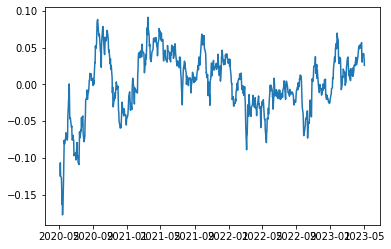

In [5]:
spread = np.log(price2) - beta * np.log(price1) - alpha
plt.plot(common_dates, spread)

## Prepare training / test data

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))

def normalize_spread(data, scaler):
    scaled_data = scaler.fit_transform(data.reshape(-1,1))
    return scaled_data


def train_test_split(dates, data, test_ratio=0.2, window_size=30):
    assert len(dates) == len(data)
    test_size = int(len(dates) * test_ratio)
    train_size = len(dates) - test_size
    X_train, y_train, X_test, y_test = [], [], [], []
    for i in range(window_size, train_size):
        X_train.append(data[i - window_size:i])
        y_train.append(data[i])
    for i in range(train_size, train_size + test_size):
        X_test.append(data[i - window_size:i])
        y_test.append(data[i])
    print(f"Finishing splitting, training size: {len(X_train)}, testing size: {len(X_test)}")
    
    return X_train, y_train, X_test, y_test, dates[:train_size], dates[train_size:]

def to_dataloader(X_train, y_train, X_test, y_test, batch_size):
    train_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    train_loader = DataLoader(train_set, batch_size=batch_size)
    test_set = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

scaled_spread = normalize_spread(spread, scaler)
X_train, y_train, X_test, y_test, train_dates, test_dates = train_test_split(common_dates, scaled_spread)
train_loader, test_loader = to_dataloader(X_train, y_train, X_test, y_test, batch_size=8)

Finishing splitting, training size: 574, testing size: 151


<ipython-input-6-7ebdf6c0d269>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  train_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))


## LSTM Model

In [7]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Define the training function
def train(model, train_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 40 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Train the model
input_dim = 1
hidden_dim = 10
output_dim = 1
num_layers = 2
learning_rate = 0.001
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
train(model, train_loader, num_epochs, learning_rate)

Epoch [1/100], Step [40/72], Loss: 0.3460
Epoch [2/100], Step [40/72], Loss: 0.0010
Epoch [3/100], Step [40/72], Loss: 0.0009
Epoch [4/100], Step [40/72], Loss: 0.0008
Epoch [5/100], Step [40/72], Loss: 0.0009
Epoch [6/100], Step [40/72], Loss: 0.0010
Epoch [7/100], Step [40/72], Loss: 0.0010
Epoch [8/100], Step [40/72], Loss: 0.0010
Epoch [9/100], Step [40/72], Loss: 0.0010
Epoch [10/100], Step [40/72], Loss: 0.0010
Epoch [11/100], Step [40/72], Loss: 0.0009
Epoch [12/100], Step [40/72], Loss: 0.0008
Epoch [13/100], Step [40/72], Loss: 0.0008
Epoch [14/100], Step [40/72], Loss: 0.0007
Epoch [15/100], Step [40/72], Loss: 0.0007
Epoch [16/100], Step [40/72], Loss: 0.0008
Epoch [17/100], Step [40/72], Loss: 0.0008
Epoch [18/100], Step [40/72], Loss: 0.0009
Epoch [19/100], Step [40/72], Loss: 0.0009
Epoch [20/100], Step [40/72], Loss: 0.0008
Epoch [21/100], Step [40/72], Loss: 0.0007
Epoch [22/100], Step [40/72], Loss: 0.0006
Epoch [23/100], Step [40/72], Loss: 0.0006
Epoch [24/100], Step

Total MSE loss: 8.975271339295432e-05


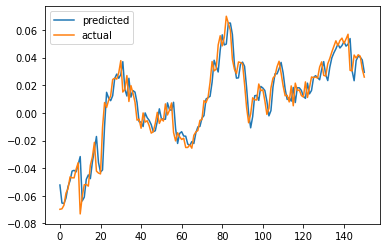

In [8]:
def test(model, test_loader):
    predictions = []
    batch_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            batch_labels.append(labels.numpy())
    return predictions, batch_labels

predictions, labels = test(model, test_loader)
predictions = scaler.inverse_transform(np.concatenate(predictions)).flatten()
labels = scaler.inverse_transform(np.concatenate(labels)).flatten()
# # # Visualize the results

plt.plot(predictions, label='predicted')
plt.plot(labels, label='actual')
print(f'Total MSE loss: {mean_squared_error(predictions, labels)}')
plt.legend()
plt.show()

## Trading Model

Suppose stock A and B are in the trade, and we modeled $$\log S_B = \beta \log S_A + \alpha$$
- Long A position: holding $1$ unit of stock A and $\beta$ unit of stock B; 
- Short A position: holding $-1$ unit of stock A and $\beta$ unit of stock B. 

Model 1 (Standard model): 
- Where $\mu$ and $\sigma$ are the statistics on the training data.
- Enter short A position when spread is over $\mu + \sigma$
- Enter long A position when spread is over $\mu - \sigma$
- Entering the position based the open price of the market

In [12]:
def simulate_standard_model(spread_pred, beta, mu, sigma, price_open_a, price_open_b, price_close_final_a, price_close_final_b):
    # Setup at t = 0
    # New idea by wenqi: if not hitting the bar, we just do nothing
        
    hold_a, hold_b = 0, 0
    invest_a, invest_b = 0, 0
    invest = 0
    histories = []
    
    # When long A, short B: consider spending money to buy A and getting money from short B at the moment
    

    num_test = len(y_test)
    for t in range(num_test):
        if spread_pred[t] < mu - 1 * sigma and invest_a != -1: # switch from long A to long B
            if invest_a == 0:
                invest_adjust = -1 + beta
            else:
                invest_adjust = (-1 - price_open_a[t] * hold_a) + (beta - price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = -1, beta
            histories.append((t, invest_adjust, 'B'))
            hold_a, hold_b = invest_a / price_open_a[t], invest_b / price_open_b[t]
            print(f'Enter long B, short A at t={t}, invest_adjustment: {invest_adjust}')
            print(f'Hold A: {hold_a}, hold B: {hold_b}\n')
            
            
        elif spread_pred[t] > mu + 1 * sigma and invest_a != 1: # switch from long B to long A
            if invest_a == 0:
                invest_adjust = 1 - beta
            else:
                invest_adjust = (1 - price_open_a[t] * hold_a) + (-beta - price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = 1, -beta
            histories.append((t, invest_adjust, 'A'))
            hold_a, hold_b = invest_a / price_open_a[t], invest_b / price_open_b[t]
            print(f'Enter long A, short B at t={t}, invest_adjustment: {invest_adjust}')
            print(f'Hold A: {hold_a}, hold B: {hold_b}\n')
            
    
    # clear all investment
    invest_adjust = hold_a * price_close_final_a + hold_b * price_close_final_b    
    invest -= invest_adjust
    print(f'Final hold before clearing: {hold_a, hold_b}')
    print(f'Final investment to clear: {invest_adjust}')
    return invest, histories
        

num_train, num_test = len(y_train), len(y_test)
mu, sigma = np.mean(spread[:num_train]), np.std(spread[:num_train])
price_open_a, price_open_b = np.array(stock1_common['Open'])[num_train:], np.array(stock2_common['Open'])[num_train:]
invest, histories = simulate_standard_model(predictions, beta, mu, sigma, price_open_a, price_open_b, price1[-1], price2[-1])
print('-' * 20)
print(f'Beta: {beta}')
print(f'Final investment: {invest}')
print(histories)

Enter long B, short A at t=0, invest_adjustment: -0.09503396843838863
Hold A: -0.005562354025976098, hold B: 0.0034144506579587884

Enter long A, short B at t=79, invest_adjustment: 0.1758877360273674
Hold A: 0.0055002475849971885, hold B: -0.003320976262611418

Final hold before clearing: (0.0055002475849971885, -0.003320976262611418)
Final investment to clear: 0.08341853900926943
--------------------
Beta: 0.9049660315616114
Final investment: -0.002564771420290657
[(0, -0.09503396843838863, 'B'), (79, 0.1758877360273674, 'A')]


In [13]:
def analyze_history(history, final_investment):
    if len(history) == 0:
        print("No trade executed")
        return
    initial_investment = 1 if history[0][2] == 'A' else beta
    print(f"Initial investment: {initial_investment}, end balance: {-final_investment}")
    print(f"Rate of return: {-final_investment / initial_investment}")

In [14]:
analyze_history(histories, invest)

Initial investment: 0.9049660315616114, end balance: 0.002564771420290657
Rate of return: 0.0028341079453168883


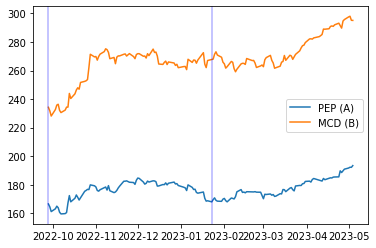

In [15]:
plt.figure()
plt.plot(test_dates, price1[num_train+30:], label='PEP (A)')
plt.plot(test_dates, price2[num_train+30:], label='MCD (B)')
for t, invest_adj, long in histories:
    plt.axvline(x=test_dates[t], color='b', alpha=0.3)
plt.legend()
plt.show()

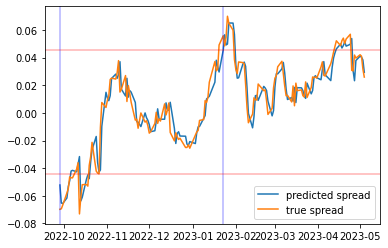

In [16]:
plt.figure()
plt.plot(test_dates, predictions, label='predicted spread')
plt.plot(test_dates, labels, label='true spread')
for t, invest_adj, long in histories:
    plt.axvline(x=test_dates[t], color='b', alpha=0.3)
plt.axhline(y=mu+sigma, color='r', alpha=0.3)
plt.axhline(y=mu-sigma, color='r', alpha=0.3)
plt.legend()
plt.show()

Model 2 (ML-based model): 
- Trading signal purely generated by spread prediction.
- Predicted change of spread: $\Delta_t = \frac{S_{t+1}^* - S_{t}}{S_t}$, where $S_t$ is the spread.
- Long A, short B if $\Delta_t > 0$ and $|\Delta_t| > \alpha_A$
- Long B, short A if $\Delta_t < 0$ and $|\Delta_t| > \alpha_B$
- For heuristic, set $\alpha_A = \alpha_B$. These values can be tuned, and the smaller they are the more frequent we trade.

In [20]:
def simulate_pure_spread_signal_model(spread_cur,
                                      spread_pred,
                                      beta,
                                      alpha_a, alpha_b,
                                      price_open_a, price_open_b, 
                                      price_close_final_a, price_close_final_b):
    # Setup at t = 0
    # New idea by wenqi: if not hitting the bar, we just do nothing
        
    assert alpha_a > 0 and alpha_b > 0
    hold_a, hold_b = 0, 0
    invest_a, invest_b = 0, 0
    invest = 0
    histories = []

    num_test = len(y_test)
    for t in range(num_test):
        abs_percent_change = abs((spread_pred[t] - spread_cur[t]) / spread_cur[t])
        if spread_pred[t] < spread_cur[t] and abs_percent_change > alpha_b and invest_a != -1: # switch from long A to long B
            if invest_a == 0:
                invest_adjust = -1 + beta
            else:
                invest_adjust = (-1 - price_open_a[t] * hold_a) + (beta - price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = -1, beta
            histories.append((t, invest_adjust, 'B'))
            hold_a, hold_b = invest_a / price_open_a[t], invest_b / price_open_b[t]
            print(f'Enter long B, short A at t={t}, invest_adjustment: {invest_adjust}')
            print(f'Signal of abs percentage change of spread: {abs_percent_change}')
            print(f'Hold A: {hold_a}, hold B: {hold_b}\n')
            
            
        elif spread_pred[t] > spread_cur[t] and abs_percent_change > alpha_a and invest_a != 1: # switch from long B to long A
            if invest_a == 0:
                invest_adjust = 1 - beta
            else:
                invest_adjust = (1 - price_open_a[t] * hold_a) + (-beta - price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = 1, -beta
            histories.append((t, invest_adjust, 'A'))
            hold_a, hold_b = invest_a / price_open_a[t], invest_b / price_open_b[t]
            print(f'Enter long A, short B at t={t}, invest_adjustment: {invest_adjust}')
            print(f'Signal of abs percentage change of spread: {abs_percent_change}')
            print(f'Hold A: {hold_a}, hold B: {hold_b}\n')
            
    
    # clear all investment
    invest_adjust = hold_a * price_close_final_a + hold_b * price_close_final_b    
    invest -= invest_adjust
    print(f'Final hold before clearing: {hold_a, hold_b}')
    print(f'Final investment to clear: {invest_adjust}')
    return invest, histories
        

num_train, num_test = len(y_train), len(y_test)
price_open_a, price_open_b = np.array(stock1_common['Open'])[num_train:], np.array(stock2_common['Open'])[num_train:]
spread_test_rolled = spread[num_train+30-1:-1]
alpha_a, alpha_b = 0.3, 0.3
invest, histories = simulate_pure_spread_signal_model(spread_test_rolled, predictions, beta, alpha_a, alpha_b, 
                                            price_open_a, price_open_b, price1[-1], price2[-1])
print('-' * 20)
print(f'Beta: {beta}')
print(f'Final investment: {invest}')
print(histories)


Enter long A, short B at t=23, invest_adjustment: 0.09503396843838863
Signal of abs percentage change of spread: 0.9875429034034743
Hold A: 0.005985873426397395, hold B: -0.003562858391974848

Enter long B, short A at t=40, invest_adjustment: -0.2596709402139652
Signal of abs percentage change of spread: 0.4844360309124158
Hold A: -0.005926628491206594, hold B: 0.0038140768544953725

Enter long A, short B at t=42, invest_adjustment: 0.18799175509814559
Signal of abs percentage change of spread: 0.381218574490217
Hold A: 0.005682464054313591, hold B: -0.0036332344022360708

Enter long B, short A at t=93, invest_adjustment: -0.16746881572126182
Signal of abs percentage change of spread: 1.0934856834099933
Hold A: -0.0054318303468046635, hold B: 0.003376738923737356

Enter long A, short B at t=97, invest_adjustment: 0.17050193240549905
Signal of abs percentage change of spread: 0.3370247869688567
Hold A: 0.005573825202541901, hold B: -0.0033989334518745966

Enter long B, short A at t=103,

In [21]:
analyze_history(histories, invest)

Initial investment: 1, end balance: 0.11398149263007162
Rate of return: 0.11398149263007162


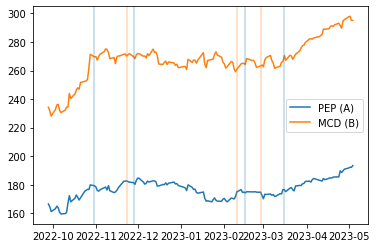

In [22]:
plt.figure()
plt.plot(test_dates, price1[num_train+30:], label='PEP (A)')
plt.plot(test_dates, price2[num_train+30:], label='MCD (B)')
for t, invest_adj, long in histories:
    if long == 'A':
        plt.axvline(x=test_dates[t], color='C0', alpha=0.3)
    else:
        plt.axvline(x=test_dates[t], color='C1', alpha=0.3)
plt.legend()
plt.show()

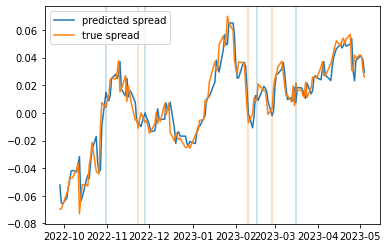

In [23]:
plt.figure()
plt.plot(test_dates, predictions, label='predicted spread')
plt.plot(test_dates, labels, label='true spread')
for t, invest_adj, long in histories:
    if long == 'A':
        plt.axvline(x=test_dates[t], color='C0', alpha=0.3)
    else:
        plt.axvline(x=test_dates[t], color='C1', alpha=0.3)
plt.legend()
plt.show()

Model 3 (Standard model variant): 
- Where $\mu$ and $\sigma$ are the statistics on the training data.
- Enter short A position when spread is over $\mu + \sigma$
- Enter long A position when spread is over $\mu - \sigma$
- **Close trade when entered long/short position but spread goes back to $\mu$**
- Entering the position based the open price of the market

In [24]:
def simulate_standard_model_2(spread_pred, beta, mu, sigma, price_open_a, price_open_b, price_close_final_a, price_close_final_b):
    # Setup at t = 0
    # New idea by wenqi: if not hitting the bar, we just do nothing
        
    hold_a, hold_b = 0, 0
    invest_a, invest_b = 0, 0
    invest = 0
    histories = []
    
    # When long A, short B: consider spending money to buy A and getting money from short B at the moment
    

    num_test = len(y_test)
    for t in range(num_test):
        if spread_pred[t] < mu - sigma and invest_a != -1: # switch from long A to long B
            # edge case: if hold_a = 0, adjust for A will just be 1
            invest_adjust = (-1 - price_open_a[t] * hold_a) + (beta - price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = -1, beta
            histories.append((t, invest_adjust, 'B'))
            hold_a, hold_b = invest_a / price_open_a[t], invest_b / price_open_b[t]
            print(f'Enter long B, short A at t={t}, invest_adjustment: {invest_adjust}')
            print(f'Hold A: {hold_a}, hold B: {hold_b}\n')
            
            
        elif spread_pred[t] > mu + 1 * sigma and invest_a != 1: # switch from long B to long A
            invest_adjust = (1 - price_open_a[t] * hold_a) + (-beta - price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = 1, -beta
            histories.append((t, invest_adjust, 'A'))
            hold_a, hold_b = invest_a / price_open_a[t], invest_b / price_open_b[t]
            print(f'Enter long A, short B at t={t}, invest_adjustment: {invest_adjust}')
            print(f'Hold A: {hold_a}, hold B: {hold_b}\n')
            
        elif (mu - sigma < spread_pred[t] < mu and invest_a == 1) or (mu < spread[t] < mu + sigma and invest_a == -1): # close
            invest_adjust = - price_open_a[t] * hold_a + (- price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = 0, 0
            hold_a, hold_b = 0, 0
            histories.append((t, invest_adjust, 'C'))
            print(f'Close trading, invest_adjustment: {invest_adjust}')
    
    # clear all investment
    invest_adjust = hold_a * price_close_final_a + hold_b * price_close_final_b    
    invest -= invest_adjust
    print(f'Final hold before clearing: {hold_a, hold_b}')
    print(f'Final investment to clear: {invest_adjust}')
    return invest, histories
        

num_train, num_test = len(y_train), len(y_test)
mu, sigma = np.mean(spread[:num_train]), np.std(spread[:num_train])
price_open_a, price_open_b = np.array(stock1_common['Open'])[num_train:], np.array(stock2_common['Open'])[num_train:]
invest, histories = simulate_standard_model_2(predictions, beta, mu, sigma, price_open_a, price_open_b, price1[-1], price2[-1])
print('-' * 20)
print(f'Beta: {beta}')
print(f'Final investment: {invest}')
print(histories)

Enter long B, short A at t=0, invest_adjustment: -0.09503396843838863
Hold A: -0.005562354025976098, hold B: 0.0034144506579587884

Close trading, invest_adjustment: 0.09426338162954462
Enter long A, short B at t=79, invest_adjustment: 0.09503396843838863
Hold A: 0.0055002475849971885, hold B: -0.003320976262611418

Close trading, invest_adjustment: -0.12257397558896943
Enter long A, short B at t=136, invest_adjustment: 0.09503396843838863
Hold A: 0.005864758854120477, hold B: -0.0034481462734615434

Final hold before clearing: (0.005864758854120477, -0.0034481462734615434)
Final investment to clear: 0.11637222914393774
--------------------
Beta: 0.9049660315616114
Final investment: -0.04964885466497393
[(0, -0.09503396843838863, 'B'), (73, 0.09426338162954462, 'C'), (79, 0.09503396843838863, 'A'), (93, -0.12257397558896943, 'C'), (136, 0.09503396843838863, 'A')]


In [25]:
analyze_history(histories, invest)

Initial investment: 0.9049660315616114, end balance: 0.04964885466497393
Rate of return: 0.054862672115217136


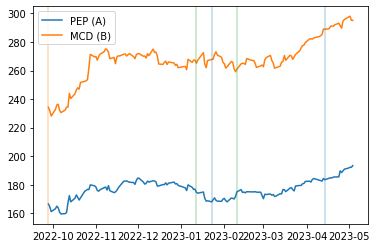

In [26]:
plt.figure()
plt.plot(test_dates, price1[num_train+30:], label='PEP (A)')
plt.plot(test_dates, price2[num_train+30:], label='MCD (B)')
for t, invest_adj, long in histories:
    if long == 'A':
        plt.axvline(x=test_dates[t], color='C0', alpha=0.3)
    elif long == 'B':
        plt.axvline(x=test_dates[t], color='C1', alpha=0.3)
    elif long == 'C':
        plt.axvline(x=test_dates[t], color='C2', alpha=0.3)
plt.legend()
plt.show()

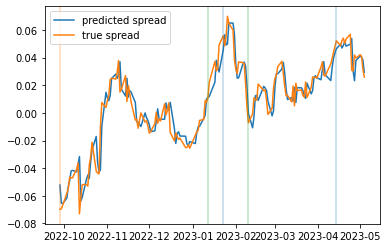

In [27]:
plt.figure()
plt.plot(test_dates, predictions, label='predicted spread')
plt.plot(test_dates, labels, label='true spread')
for t, invest_adj, long in histories:
    if long == 'A':
        plt.axvline(x=test_dates[t], color='C0', alpha=0.3)
    elif long == 'B':
        plt.axvline(x=test_dates[t], color='C1', alpha=0.3)
    elif long == 'C':
        plt.axvline(x=test_dates[t], color='C2', alpha=0.3)
plt.legend()
plt.show()

Model 4 (Hybrid model variant):

TODO: define how to adjust upper and lower bound with respect to volatility